<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/APPLE_VISION_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch transformers Pillow requests -q

Attempting to download image from: https://upload.wikimedia.org/wikipedia/commons/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg
Image downloaded and loaded successfully. Image size: (3389, 2209)


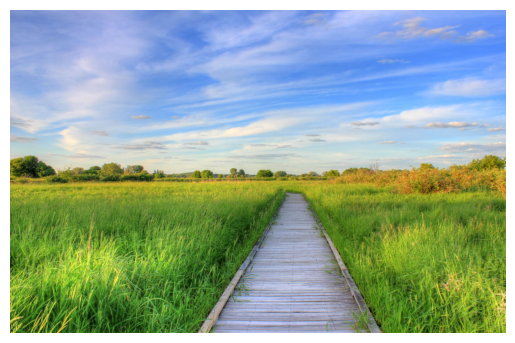


Loading FastVLM model...
Model loaded successfully.
Running on device: cuda:0 with dtype: torch.float16
Preprocessing image...
Generating description...

--- FastVLM Clean Output ---

In this captivating photograph, a tranquil pathway of light cedar-colored wooden planks meanders through a vast and lush landscape, inviting viewers into a serene natural environment. The path, bordered by green blades of grass and other dense vegetation, ascends gently before transitioning straight. It is composed of light wood, contrasting sharply with the dark green backdrop and guiding the eye back and forth. On both sides, the verdant grass extends upwards towards the sky, adding to the expanse of greenery. Beyond this grassy meadow, a dense line of trees extends horizontally across the horizon, their fullness visible only through narrow slits.

The tree line at the horizon suggests this could be either the edge of a field, where the flora begins to thicken, or the beginning of a wooded area. Above 

In [2]:
import torch
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM
import requests
from io import BytesIO
import warnings
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import cv2

# Suppress the FutureWarning about torch_dtype being deprecated
warnings.filterwarnings("ignore", category=FutureWarning, message="`torch_dtype` is deprecated! Use `dtype` instead!")

# --- 🎯 Image Setup: Download and Load ---
# The target Wikipedia image URL with a User-Agent header to avoid 403 Forbidden errors
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

try:
    print(f"Attempting to download image from: {IMAGE_URL}")
    response = requests.get(IMAGE_URL, headers=HEADERS)
    response.raise_for_status()
    # Load the image from the content bytes
    img = Image.open(BytesIO(response.content)).convert("RGB")
    print(f"Image downloaded and loaded successfully. Image size: {img.size}")
except Exception as e:
    print(f"CRITICAL ERROR: Failed to download image from the provided URL: {e}")
    print("Exiting script.")
    exit()

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()
print()

# -------------------------------------------------------------

# --- 💻 FastVLM Inference Code ---

# Model ID for FastVLM-1.5B
MID = "apple/FastVLM-1.5B"
IMAGE_TOKEN_INDEX = -200  # The specific token ID FastVLM uses for the image placeholder

# 1) Load Model and Tokenizer
print("Loading FastVLM model...")
# Determine device and dtype
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

tok = AutoTokenizer.from_pretrained(MID, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MID,
    dtype=dtype,
    device_map=device,
    trust_remote_code=True,
)
print("Model loaded successfully.")
print(f"Running on device: {model.device} with dtype: {model.dtype}")


# 2) Build chat -> render to string (not tokens) so we can place <image> exactly
messages = [
    {"role": "user", "content": "<image>\nDescribe this image in detail."}
]
rendered = tok.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=False
)
assert "<image>" in rendered, "The chat template output must contain <image> once."

pre, post = rendered.split("<image>", 1)

# 3) Tokenize the text *around* the image token (no extra specials!)
pre_ids  = tok(pre,  return_tensors="pt", add_special_tokens=False).input_ids
post_ids = tok(post, return_tensors="pt", add_special_tokens=False).input_ids

# 4) Splice in the IMAGE token id (-200) at the placeholder position
img_tok = torch.tensor([[IMAGE_TOKEN_INDEX]], dtype=pre_ids.dtype)
input_ids = torch.cat([pre_ids, img_tok, post_ids], dim=1).to(model.device)
attention_mask = torch.ones_like(input_ids, device=model.device)

# 5) Preprocess image via the model's own processor
print("Preprocessing image...")
px = model.get_vision_tower().image_processor(images=img, return_tensors="pt")["pixel_values"]
px = px.to(model.device, dtype=model.dtype)

# 6) Generate
print("Generating description...")

# Set the standard EOS token ID and PAD token ID for stable generation
eos_id = model.config.eos_token_id
# Use the EOS ID for padding if PAD ID is not explicitly set
pad_id = model.config.pad_token_id if model.config.pad_token_id is not None else eos_id

with torch.no_grad():
    out = model.generate(
        inputs=input_ids,
        attention_mask=attention_mask,
        images=px,
        max_new_tokens=512,
        eos_token_id=eos_id,  # Use the model's standard end-of-sequence token
        pad_token_id=pad_id,
    )

# 7) Output Result
# The model's intended stop sequence is "<end of detailed description>".
# Even with eos_token_id set, the model might include this special token.
# We decode the output and manually clean it up to ensure only the description remains.
result = tok.decode(out[0], skip_special_tokens=False)

# Clean up by removing the prompt and anything after the common stop marker
start_of_desc = "Describe this image in detail."
end_of_desc = "<end of detailed description>"

if start_of_desc in result:
    # Remove the initial prompt text
    result = result.split(start_of_desc)[-1].strip()

if end_of_desc in result:
    # Remove the stop token and everything that follows it
    result = result.split(end_of_desc)[0].strip()

# Final cleanup by skipping all special tokens
final_result = tok.decode(tok.encode(result), skip_special_tokens=True)

print("\n--- FastVLM Clean Output ---\n")
print(final_result.strip())
print("\n----------------------")